# EE613 - Nonlinear Regression I - Exercise 2: LWR and GMR

In [125]:
import sys
sys.path.append('../lib')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from mixture_model import *
from plot_utils import *
from scipy.stats import norm as normal_dist

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate Data 

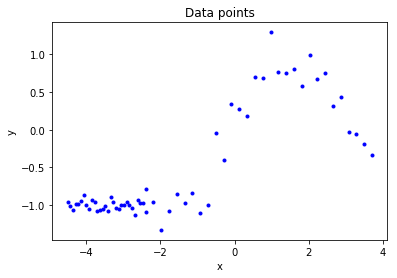

In [127]:
nb_data = 30
x1 = np.linspace(-4.5,-2.4,nb_data)
y1 = -1*np.ones(nb_data)[:,None] + np.random.normal(size=(nb_data, 1))*6e-2 

x2 = np.linspace(-2.4,3.7,nb_data)
y2 = np.sin(1*x2)[:,None] + np.random.normal(size=(nb_data, 1))*2e-1 

x = np.concatenate([x1,x2])
Y = np.vstack([y1,y2])

plt.plot(x,Y, '.b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data points')
plt.show()

In [103]:
x_test = np.linspace(-8,5)

***

### Question 1: Computing LWR

Given the data {X,Y}, approximate the function $f(x) = y$ by LWR. Then, use the LWR to compute the prediction, given x_test, and plot the prediction.

Use 3 Radial Basis Functions (RBFs). Manually define the center and the width of the basis functions. Try to vary these parameters and see what happens on the prediction. 

Observe the prediction outside the training data (when x < -2.4 or x > 3.7). How do you explain this? 

Note: you can use or not use polynomial expansion of the input x. Start without the polynomial expansion first. 

### Q1 Solution 

#### Define the radial basis functions for LWR

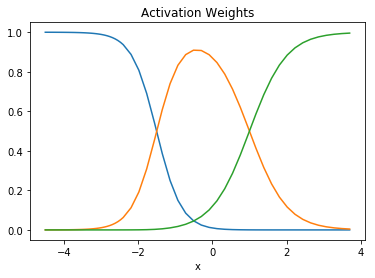

In [104]:
n_states = 3
#set the mean of the basis functions
mus = np.array([-3,0.,2.])
#set the width of the basis functions
sigmas = np.array([1.]*n_states)

#Compute the activation weigths
H = np.zeros((n_states, 2*nb_data))
for i in range(n_states):
    H[i] = normal_dist(loc = mus[i], scale = np.sqrt(sigmas[i])).pdf(x)
H /= np.sum(H,axis=0) #normalizing the weights

#plot the radial basis functions
for i in range(n_states):
    plt.plot(x, H[i],'-')

plt.xlabel('x')
plt.title('Activation Weights')
plt.show()

#### Define the LWR input

Here we use [1, x] as the input

In [105]:
X = np.vstack([np.ones(len(x)), x]).T

#### Calculate the LWR Parameters $A_k$

In [106]:
#calculate a set of parameters for each state
As = []
for i in range(n_states):
    W = np.diag(H[i])
    A = dot(inv(dot(X.T,dot(W,X))+np.eye(2)*1e-7),dot(X.T, dot(W,Y)))
    As.append(A)

### Calculate the prediction

#### Calculate the activation weights for x_test

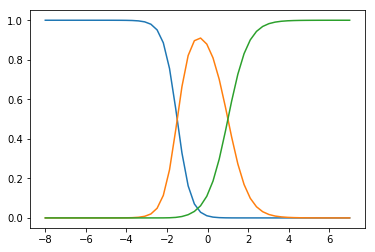

In [107]:
x_test = np.linspace(-8,7)
H_test = np.zeros((n_states, len(x_test)))
for i in range(n_states):
    H_test[i] = normal_dist(loc = mus[i], scale = np.sqrt(sigmas[i])).pdf(x_test)
H_test /= np.sum(H_test,axis=0) #normalizing the weights

#plot the radial basis functions
for i in range(n_states):
    plt.plot(x_test, H_test[i],'-')

#### Define the input 

In [108]:
X_test = np.vstack([np.ones(len(x_test)), x_test]).T

#### Calculate the prediction 

Text(0,0.5,'y')

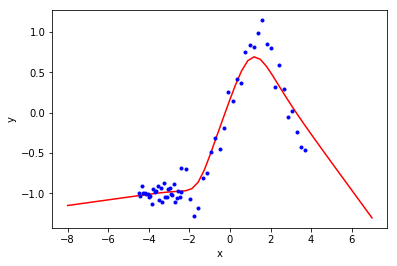

In [109]:
Y_preds = []
for i in range(n_states):
    Y_pred = np.multiply(H_test[i][:,None], dot(X_test,As[i]))
    Y_preds.append(Y_pred)
    
Y_preds = np.array(Y_preds)

Y_preds = np.sum(Y_preds, axis=0)

plt.plot(x_test, Y_preds,'-r', alpha=1)
plt.plot(x,Y, '.b')
plt.xlabel('x')
plt.ylabel('y')

***

### Question 2: Computing GMR
Given the data {X,Y}, approximate the function $f(x) = y$ by GMR. Then, use the GMR to compute the prediction, given x_test, and plot the prediction (both the mean and the covariance).

What is the difference between LWR and GMR that you observe?

### Q2 Solution 

#### Concatenate the input (x) to the output (y) 

In [119]:
data_joint = np.vstack([x, Y.flatten()]).T
D = data_joint.shape[1]

#### Estimate GMM using the data 

In [120]:
from IPython.display import clear_output

[1.0, 1.0, 1.0]


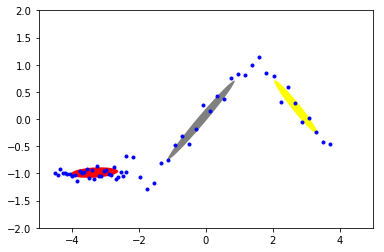

In [121]:
gmm = GMM(D=D,K=n_states,M=1,N=1000)
gmm.fit(data_joint)
clear_output()
#plot only the spatial components
fig, ax = plt.subplots(figsize = (6,4))
colors = [[1.,0.,0.],[1.,1.,0.],[0.5,0.5,0.5],[0.,1.,1.],[0.,1.,0.],[0.,0.,1.],]
plot_GMM(gmm.means_, gmm.covariances_,ax,colors=colors)
plt.axis([-5,5,-2,2])
plt.plot(x,Y, '.b')

#### Create a GMR class 

In [122]:
dim_in = slice(0,1)
dim_out = slice(1,2)
gmr = GMR(gmm,dim_in = dim_in, dim_out = dim_out)

#### Predict the data based on the time input

In [123]:
y_preds = []
covs = []
x_test = np.linspace(-8,5)
for x_i in x_test:
    y,cov = gmr.predict(x_i)
    y_preds.append(y)
    covs.append(cov)
    
y_preds = np.array(y_preds)
covs = np.array(covs)

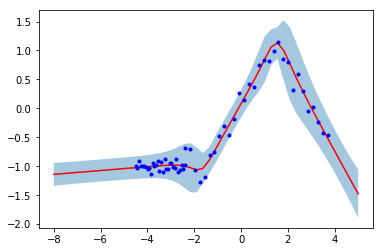

In [124]:
fig,ax = plt.subplots()
plot_with_covs_1D(x_test,y_preds.flatten(),covs.flatten(),ax)
plt.plot(x,Y, '.b')

***